In [1]:
import numpy as np
import pandas as pd
import os
from sklearn import linear_model

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

# Figure 7. Validate CSDL against ARMS crop rotation statistics

In [2]:
# if needed, change this to the directory containing your data and the name of your data file
arms_dir = '../data/arms_rotation/'
csdl_dir = '../data/csdl_rotation/'

Agricultural Resource Management Survey (ARMS) crop rotation data was downloaded from the "Tailored reports: Crop Production Practices" found at https://www.ers.usda.gov/data-products/arms-farm-financial-and-crop-production-practices/.

In [3]:
# load ARMS data
arms = pd.read_csv(os.path.join(arms_dir, 'ARMS_priorCrop.csv'))
arms = arms.rename({'corn_estimate': 'arms_corn', 'soy_estimate': 'arms_soy', 'state':'STATE_ABBR'}, axis=1)
print(arms.shape)
arms.head()

(39, 8)


,STATE_ABBR,year,arms_corn,corn_RSE,corn_stat_unreliable,arms_soy,soy_RSE,soy_stat_unreliable
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0


Crop rotation implied by CSDL maps was computed and exported in Google Earth Engine.

In [4]:
# load 2001, 2005 and 2010 data for CSDL
csdl_2001 = pd.read_csv(os.path.join(csdl_dir, '2001_CSDL_cropsYearPrior_corn.csv'))
csdl_2005 = pd.read_csv(os.path.join(csdl_dir, '2005_CSDL_cropsYearPrior_corn.csv'))
csdl_2010 = pd.read_csv(os.path.join(csdl_dir, '2010_CSDL_cropsYearPrior_corn.csv'))
csdl = pd.concat([csdl_2001, csdl_2005, csdl_2010], axis=0)
csdl = csdl.drop(['system:index', 'DRAWSEQ', 'SUB_REGION', 'groups', '.geo'], axis=1)
csdl = csdl.rename({'1': 'csdl_corn','5': 'csdl_soy', '0': 'csdl_other'}, axis=1)
print(csdl.shape) # 13states * 3years = 39
csdl.head()

(39, 9)


,csdl_corn,255,csdl_soy,9,STATE_ABBR,STATE_FIPS,STATE_NAME,area,year
0,3.102666e+09,217800.0,3.802626e+09,2.723662e+09,MI,26,Michigan,72555800.0,2001
1,8.069069e+09,792000.0,3.439302e+09,2.962841e+09,WI,55,Wisconsin,70941500.0,2001
2,3.310444e+09,63900.0,1.698983e+10,2.261517e+09,MN,27,Minnesota,113537000.0,2001
3,3.559528e+08,2700.0,8.541046e+08,1.389234e+09,ND,38,North Dakota,99086800.0,2001
4,3.199971e+09,45000.0,9.031448e+09,4.797822e+09,SD,46,South Dakota,96940000.0,2001


In [5]:
# merge datasets
df = arms.merge(csdl, on=['STATE_ABBR', 'year'], how='left')

df['arms_tot'] = df['arms_corn'] + df['arms_soy']
df['arms_corn_corn'] = df['arms_corn'] / df['arms_tot']
df['arms_soy_corn'] = df['arms_soy'] / df['arms_tot']

df['csdl_tot'] = df['csdl_corn'] + df['csdl_soy']
df['csdl_corn_corn'] = df['csdl_corn'] / df['csdl_tot']
df['csdl_soy_corn'] = df['csdl_soy'] / df['csdl_tot']

df['csdl_ratio_soy_corn'] = df['csdl_soy'] / df['csdl_corn']
df['arms_ratio_soy_corn'] = df['arms_soy'] / df['arms_corn']

df.head()

,STATE_ABBR,year,arms_corn,corn_RSE,corn_stat_unreliable,arms_soy,soy_RSE,soy_stat_unreliable,csdl_corn,255,...,STATE_NAME,area,arms_tot,arms_corn_corn,arms_soy_corn,csdl_tot,csdl_corn_corn,csdl_soy_corn,csdl_ratio_soy_corn,arms_ratio_soy_corn
0,ND,2001,114.89,0.0,1.0,252.66,0.0,1.0,3.559528e+08,2700.000000,...,North Dakota,99086800.0,367.55,0.312583,0.687417,1.210057e+09,0.294162,0.705838,2.399488,2.199147
1,SD,2001,398.77,0.0,1.0,2796.68,0.0,0.0,3.199971e+09,45000.000000,...,South Dakota,96940000.0,3195.45,0.124793,0.875207,1.223142e+10,0.261619,0.738381,2.822353,7.013266
2,NE,2001,3215.92,0.0,0.0,4186.42,0.0,0.0,2.257429e+10,186300.000000,...,Nebraska,88396600.0,7402.34,0.434446,0.565554,3.400298e+10,0.663892,0.336108,0.506270,1.301780
3,KS,2001,922.64,0.0,0.0,1416.65,0.0,0.0,6.957866e+09,48600.000000,...,Kansas,86012200.0,2339.29,0.394410,0.605590,9.640484e+09,0.721734,0.278266,0.385552,1.535431
4,MO,2001,152.78,0.0,1.0,2409.23,0.0,0.0,3.084553e+09,122396.470588,...,Missouri,72863800.0,2562.01,0.059633,0.940367,9.718559e+09,0.317388,0.682612,2.150718,15.769276


/home/swang222/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


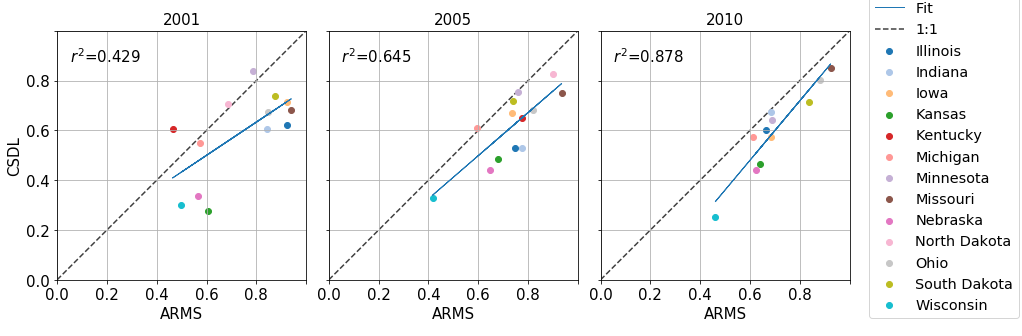

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
fsize = 15

NUM_COLORS = 13
cm = plt.get_cmap('tab20')
lm = linear_model.LinearRegression()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)

for i,(id,group) in enumerate(df.groupby('year')):
    
    ax[i].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    ax[i].set_title(id,fontsize=fsize)
    ax[i].set_xlabel('ARMS', fontsize=fsize)
    
    for id2,group2 in group.groupby('STATE_NAME'):
        ax[i].scatter(group2['arms_soy_corn'],group2['csdl_soy_corn'],label=id2)

    group= group.dropna(subset=['arms_soy_corn', 'csdl_soy_corn'])
    model = lm.fit(group[['arms_soy_corn']], group['csdl_soy_corn'])
    R2 = lm.score(group[['arms_soy_corn']], group['csdl_soy_corn'])

    predictions = lm.predict(group[['arms_soy_corn']])
    ax[i].plot(group[['arms_soy_corn']], predictions, linewidth=1)
    ax[i].text(0.05, 0.9, '$r^2$={0:.3f}'.format(R2), ha="left", va="center", 
               size=fsize, bbox=bbox_props, transform=ax[i].transAxes)

    # plot 1:1 line
    ax[i].plot([0,1], [0,1], 'k--', alpha=0.75, zorder=0)
    ax[i].set_aspect('equal')
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].grid(True)
    ax[i].legend().set_visible(False)
    
    ax[i].set_yticklabels('', rotation=0)

ax[0].set_ylabel('CSDL',fontsize=fsize)
ylabels = xlabels = np.arange(0,10, 2)/10
ax[0].set_yticklabels(ylabels,fontsize=fsize)
ax[0].set_xticklabels(xlabels,fontsize=fsize)
ax[1].set_xticklabels(xlabels,fontsize=fsize)
ax[2].set_xticklabels(xlabels,fontsize=fsize)


# Create the legend
colors=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
mylabels = ['Fit','1:1','Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Michigan', 'Minnesota',
 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']

fig.legend(lines,     # The line objects
           labels=mylabels,   # The labels for each line
           loc="lower right",   # Position of legend
           bbox_to_anchor=(0.95, 0.03),
           fontsize='x-large')

fig.tight_layout(rect=[0,0,0.8,1])
fig.show()